Names and IDs : Ardalan Gerami 99102112 - Arman LotfAliKhani 99109166

Above all we import necessery libraries.

In [1]:
from scipy import signal
from scipy.io import loadmat
import numpy as np
import sklearn
import os
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Now We should load our dataset. we have used the introduced dataset in project file.
dataset : DB3 - first trials of subject 1,6,9

In [2]:
def load_dataset(path_str: str):
    path=os.path.join(os.getcwd(),path_str)
    dataset=loadmat(path)
    stimulus_labels=np.transpose(dataset['stimulus'])[0]
    signals=dataset['emg']
    return stimulus_labels, signals

In [3]:
s1_stimulus_labels,s1_trial1 = load_dataset('S1_E1_A1.mat')
s2_stimulus_labels,s2_trial1 = load_dataset('S2_E1_A1.mat')
s9_stimulus_labels,s9_trial1 = load_dataset('S9_E1_A1.mat')

print(s1_trial1.shape[:])
print(s2_trial1.shape[:])
print(s9_trial1.shape[:])

(1825008, 12)
(1775674, 12)
(1762081, 12)


Now let's preprocess our dataset to cancel the noises.

In [9]:
def butter_highpass(cutoff, fs, order=4):
    b, a = signal.butter(order, cutoff, btype='high', analog=False, fs=fs)
    return b, a

def notch_filter(freq, fs, Q=30):
    b, a = signal.iirnotch(freq, Q, fs=fs)
    return b, a

def preprocessing(signals, fs, Q, cutoff, notch_freq):
    filtered_signals = np.zeros_like(signals)

    bh, ah = butter_highpass(cutoff, fs, order=4)
    bn, an = notch_filter(notch_freq, fs, Q)
    for i in range(signals.shape[1]):
        filtered_signals[:,i]=signal.filtfilt(bh, ah, signal.filtfilt(bn,an, signals[:,i]))
    
    return filtered_signals


In [10]:
def compute_spectrum(trial_data, filtered_trial_data, fsrate):
    spectrum_data = {'before': [], 'after': [], 'freq_before': [], 'freq_after': []}
    
    for i in range(trial_data.shape[1]):
        for data, key in [(filtered_trial_data, 'after'), (trial_data, 'before')]:
            L = len(data[:, i])
            Y = np.fft.fft(data[:, i])
            P = np.abs(Y / L)
            spectrum = P[:L // 2 + 1]
            spectrum[1:-1] = 2 * spectrum[1:-1]
            spectrum_data[f'freq_{key}'].append(fsrate * np.arange((L // 2) + 1) / L)
            spectrum_data[key].append(spectrum)
    
    return spectrum_data

def spectrum_a(s1_trial1, s2_trial1, s9_trial1, filtered_s1_trial1, filtered_s2_trial1, filtered_s9_trial1, fsrate):
    s1_spectrum = compute_spectrum(s1_trial1, filtered_s1_trial1, fsrate)
    s2_spectrum = compute_spectrum(s2_trial1, filtered_s2_trial1, fsrate)
    s9_spectrum = compute_spectrum(s9_trial1, filtered_s9_trial1, fsrate)
    
    return s1_spectrum, s2_spectrum, s9_spectrum

In [11]:
cutoff = 1.0
notch_freq = 50.0
fs = 2000
Q = 30

filtered_s1_trial1 = preprocessing(s1_trial1, fs, Q, cutoff, notch_freq)
filtered_s2_trial1 = preprocessing(s2_trial1, fs, Q, cutoff, notch_freq)
filtered_s9_trial1 = preprocessing(s9_trial1, fs, Q, cutoff, notch_freq)
s1_spectrum, s2_spectrum, s9_spectrum = spectrum_a(s1_trial1, s2_trial1, s9_trial1, filtered_s1_trial1, filtered_s2_trial1, filtered_s9_trial1, 2000)

- Part a : plotting spectrum of the signal after and before the preprocessing.

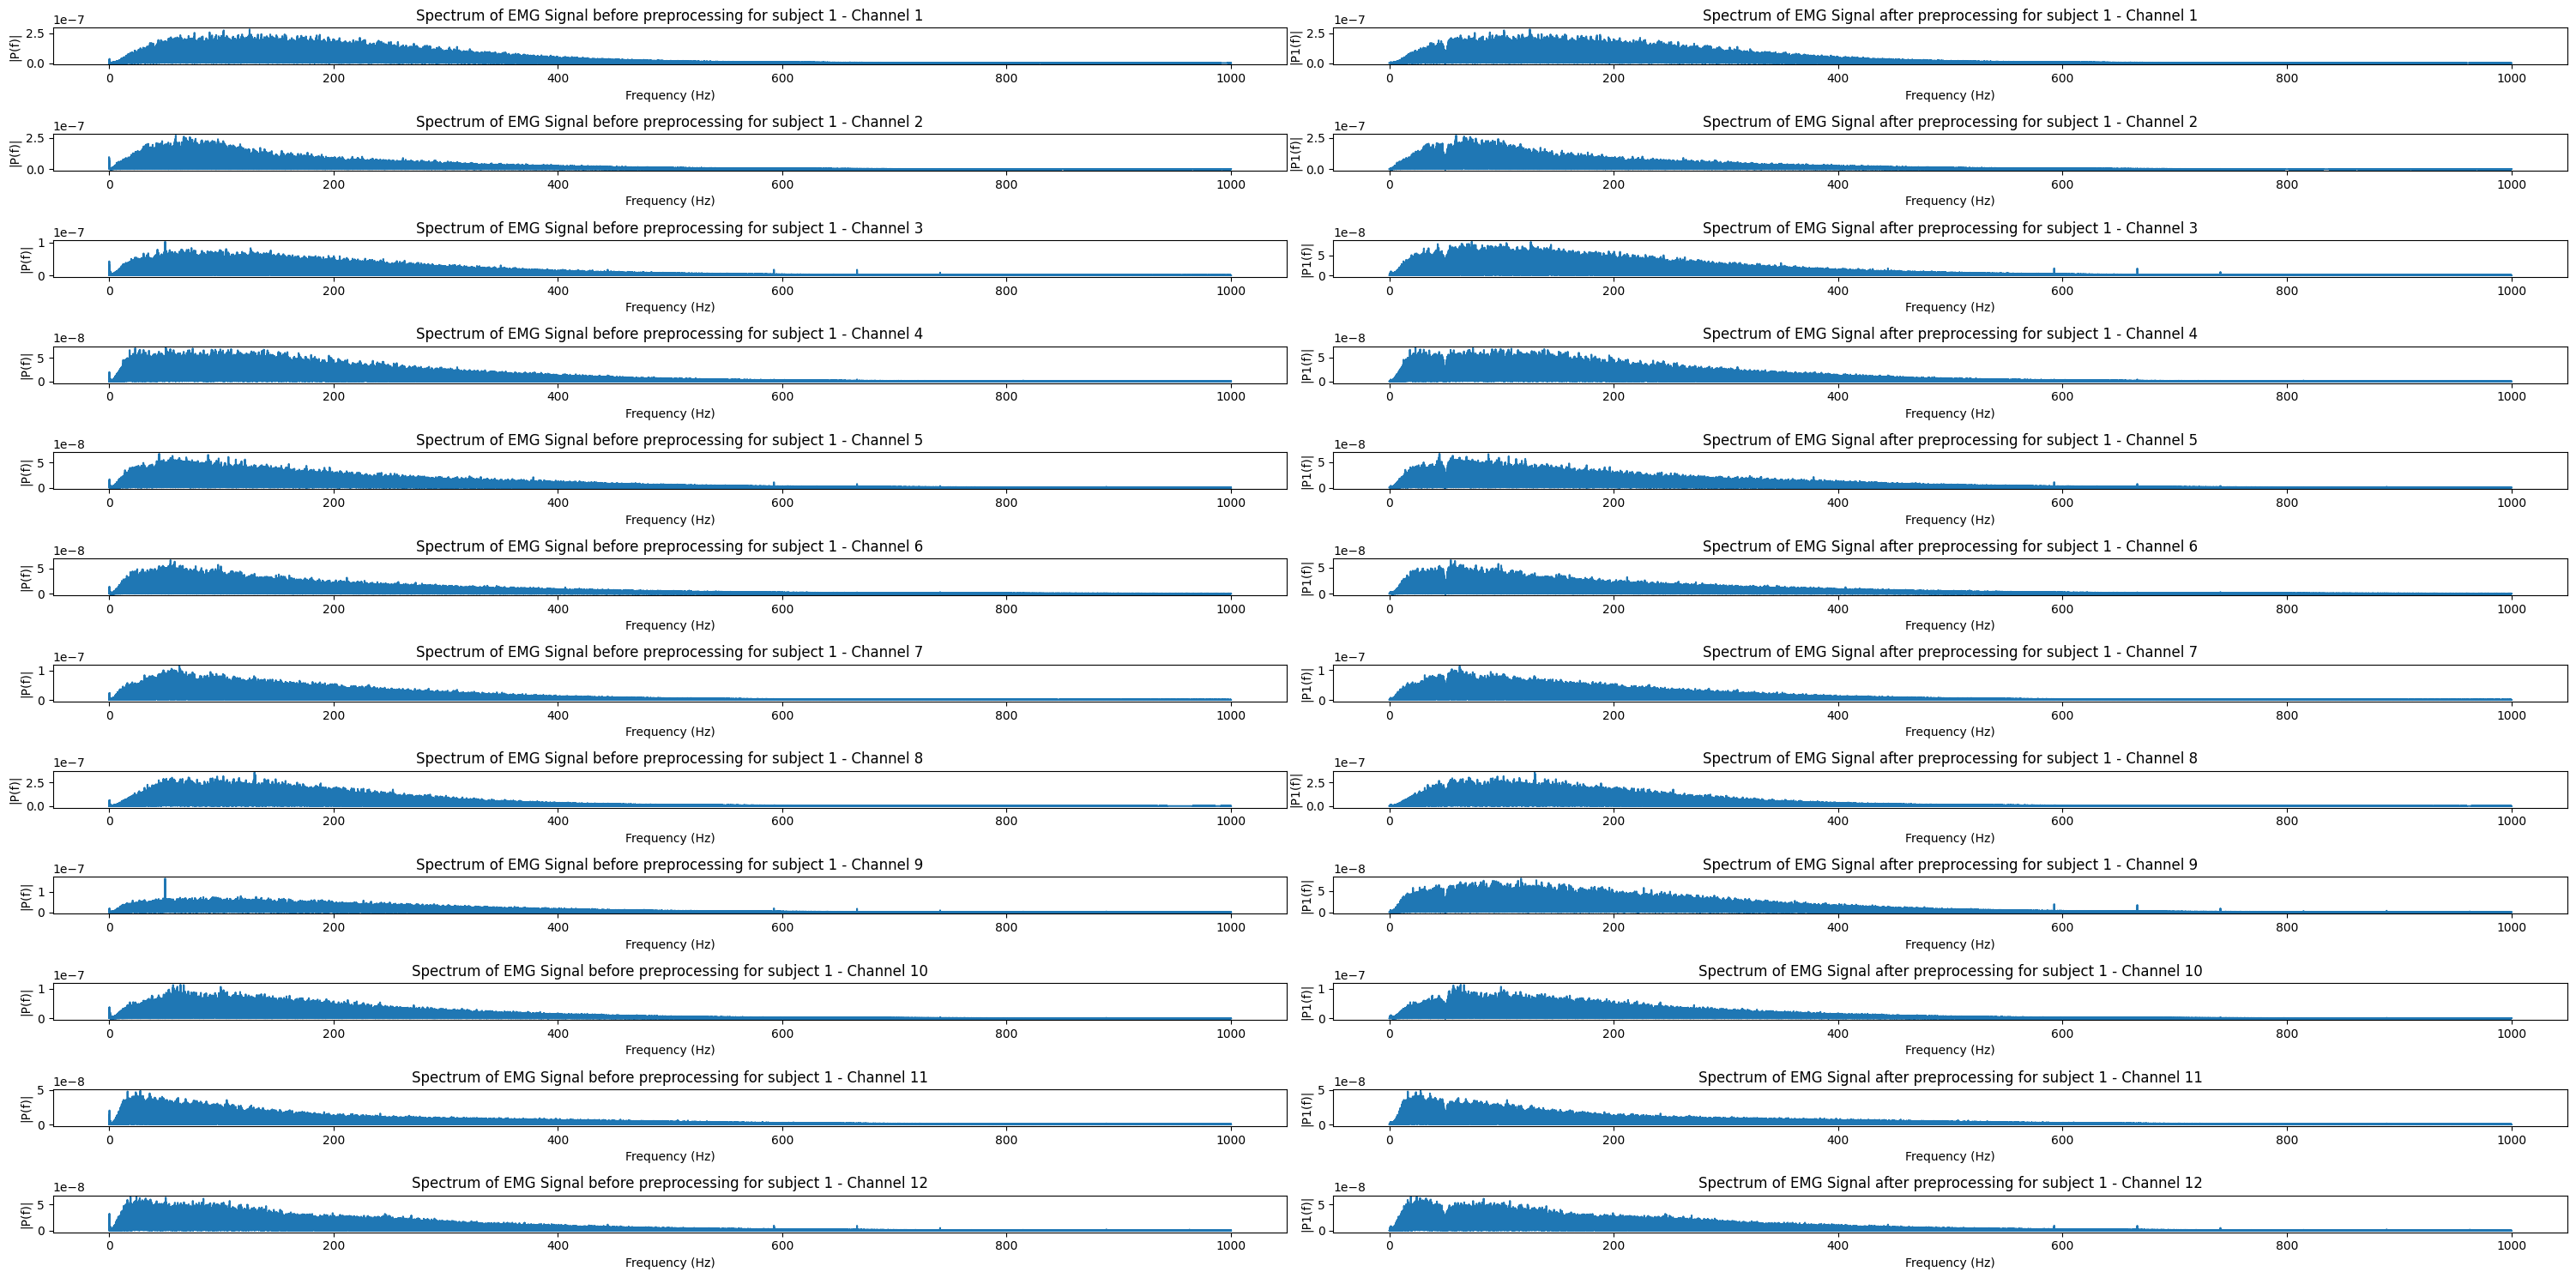

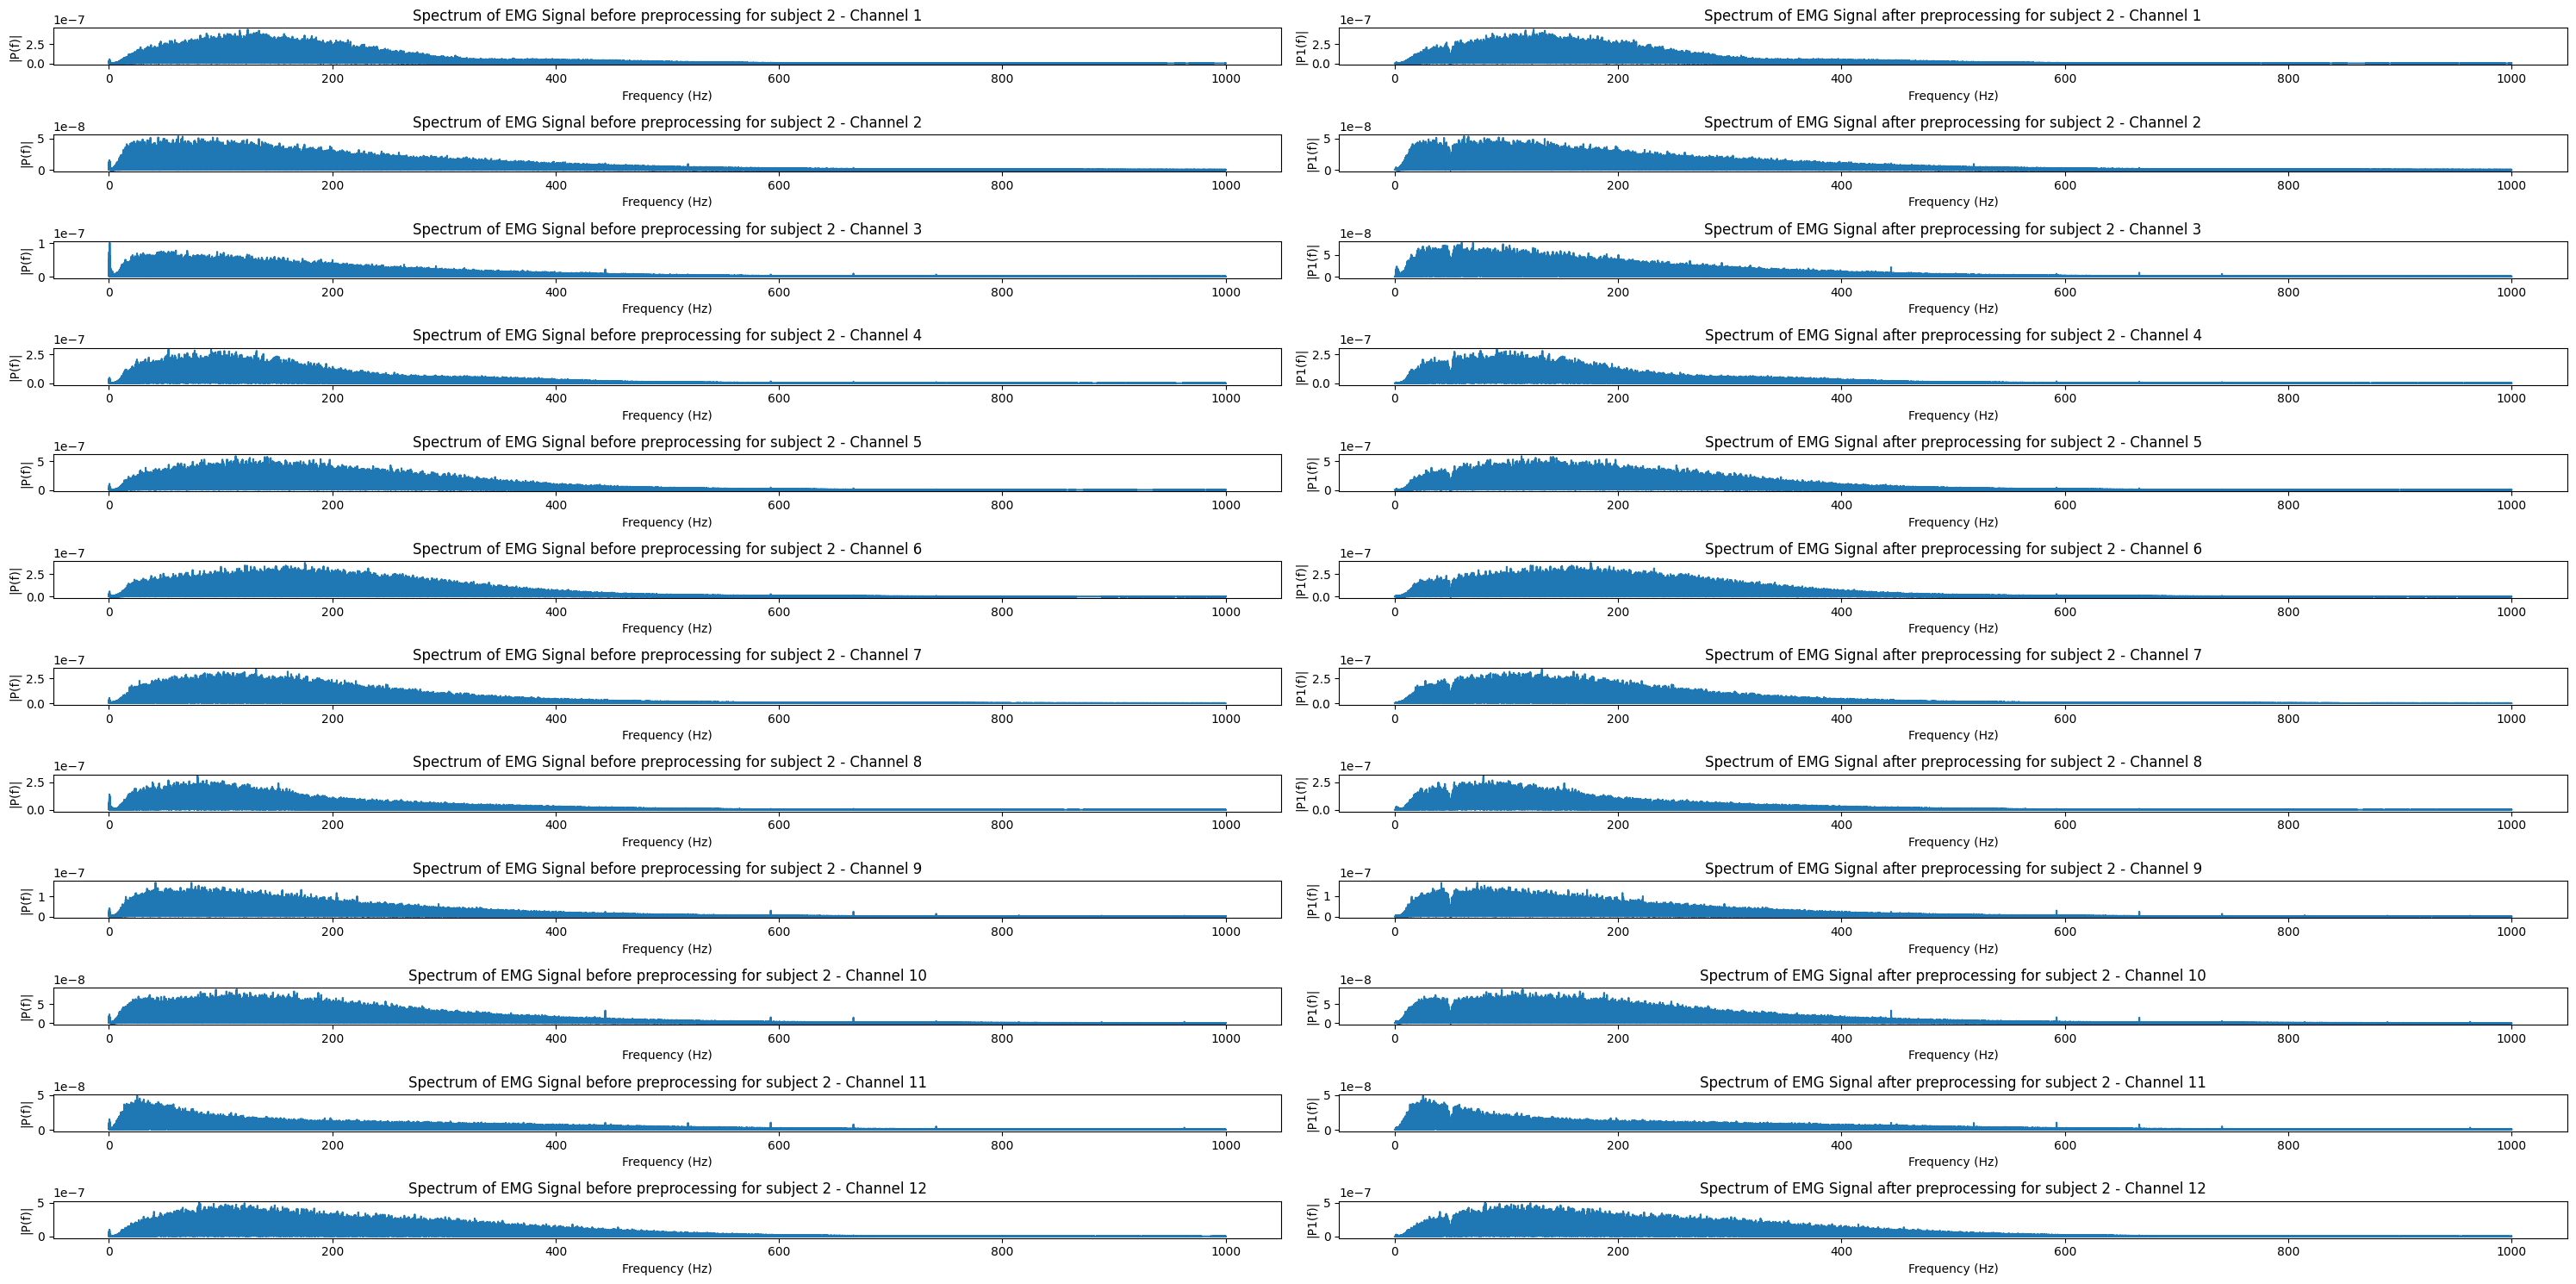

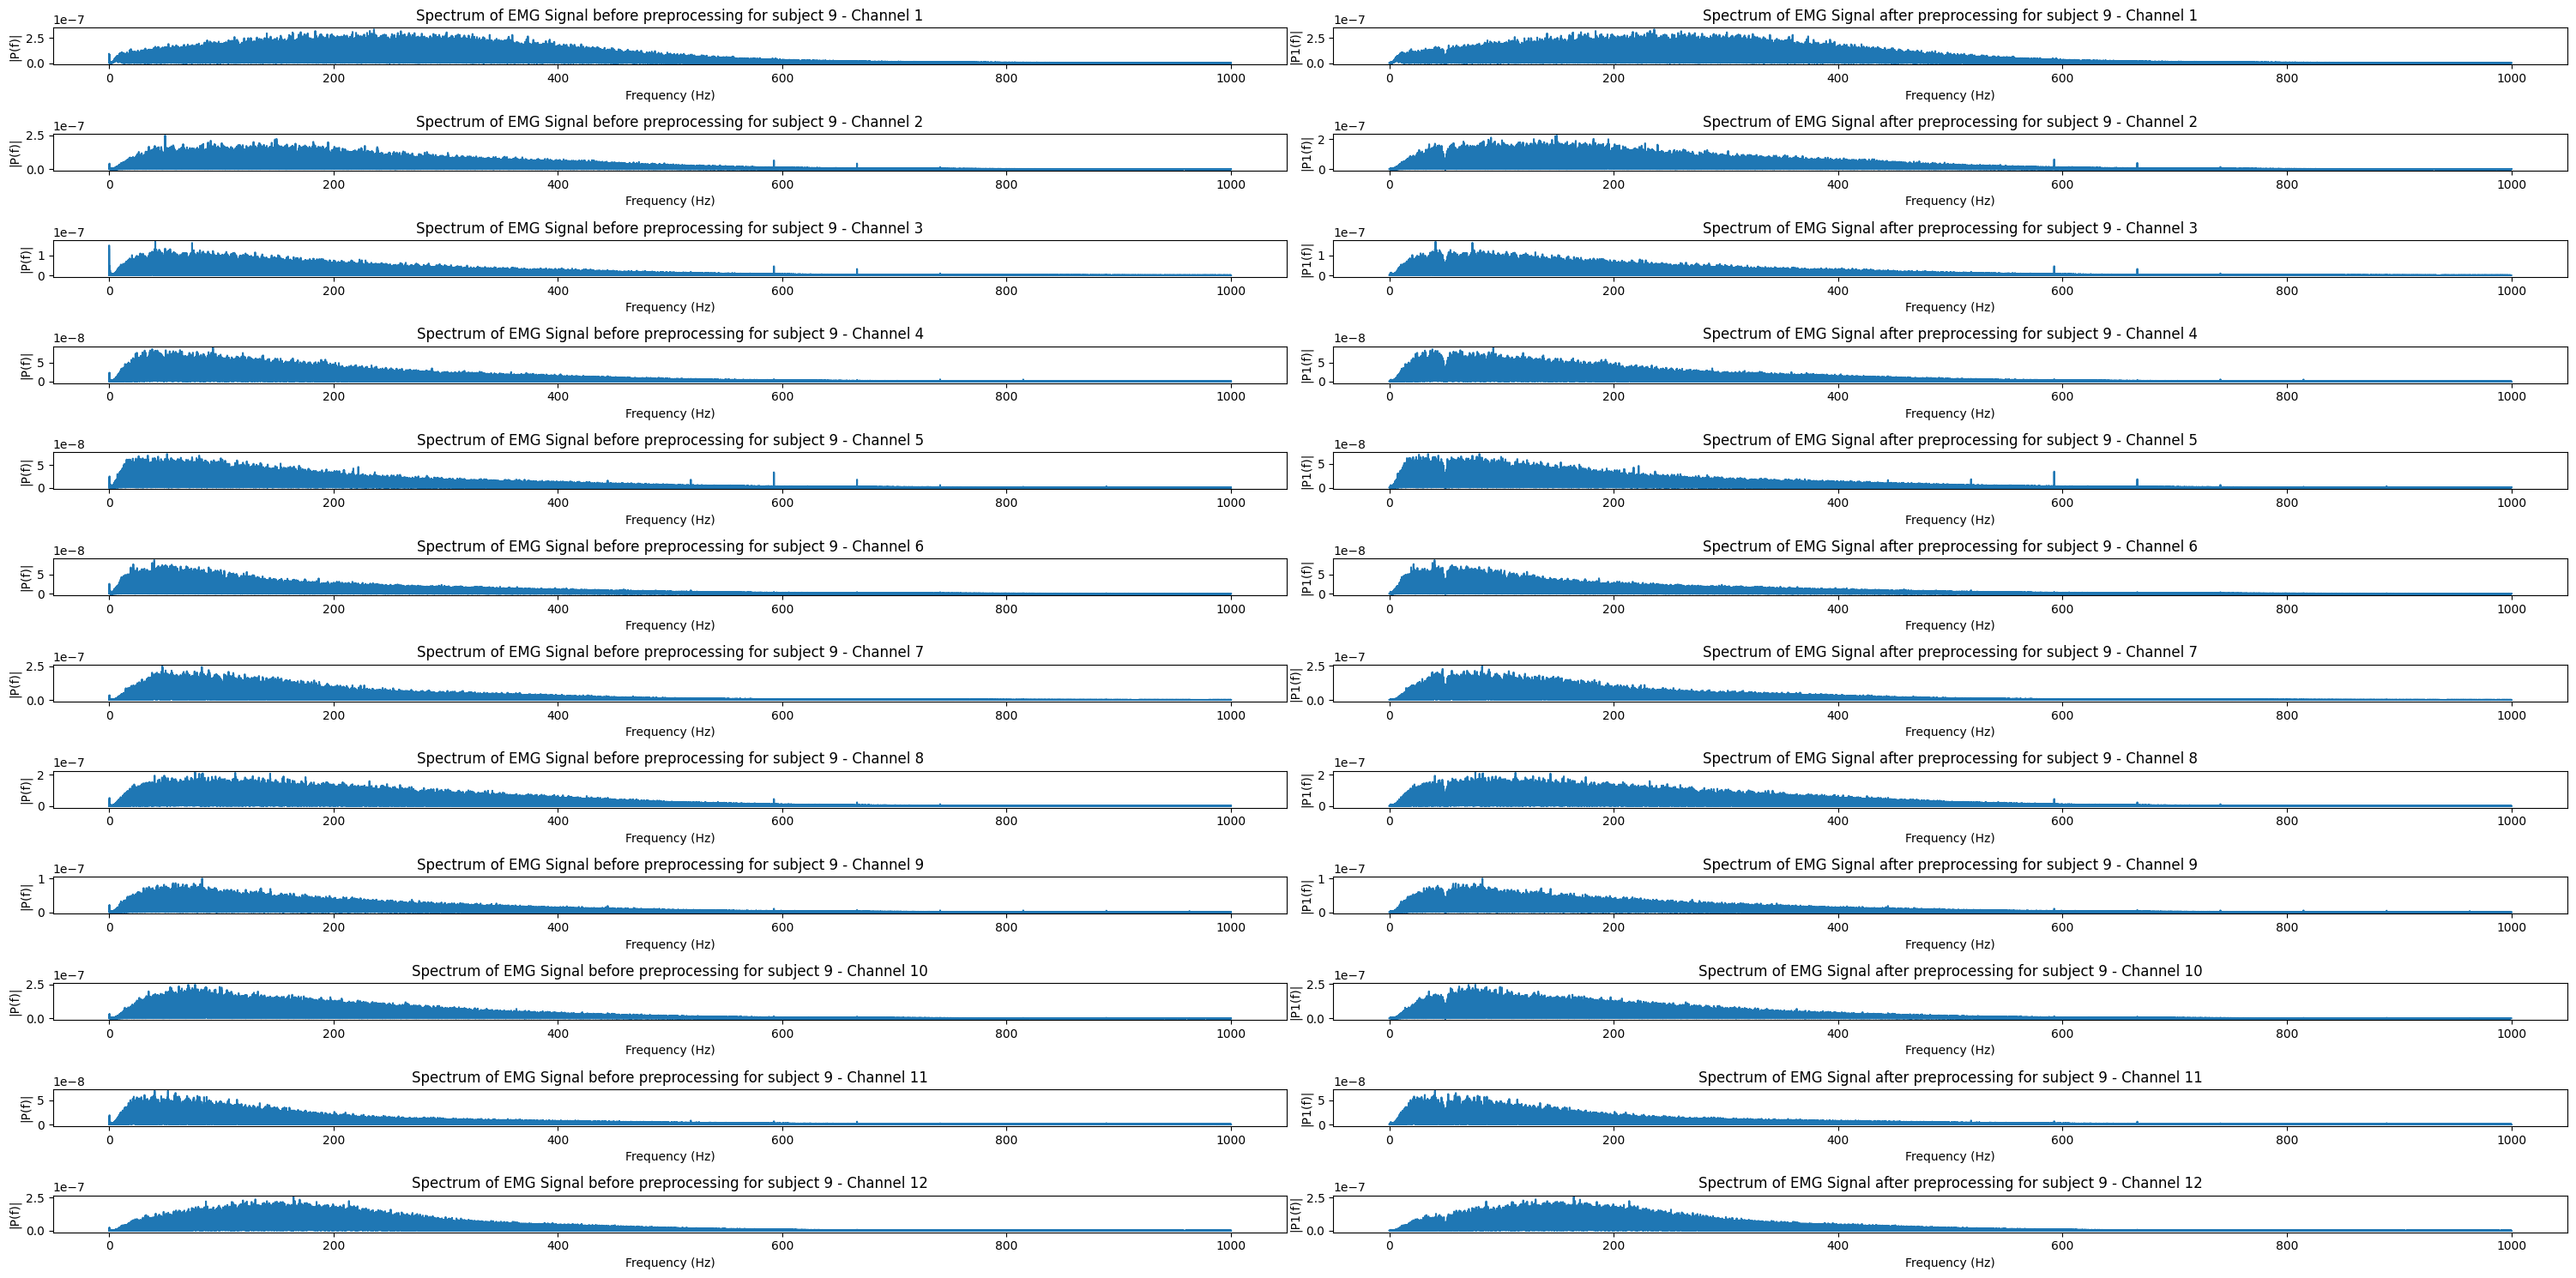

In [12]:
def plot_spectrums(spectrum, name: str):
    fig, axs = plt.subplots(12, 2, figsize=(30, 15))
    for i in range(12):
        row, col = i, 0
        axs[row, col].plot(spectrum['freq_before'][i], spectrum['before'][i])
        axs[row, col].set_title(f'Spectrum of EMG Signal before preprocessing for subject {name} - Channel {i+1}')
        axs[row, col].set_xlabel('Frequency (Hz)')
        axs[row, col].set_ylabel('|P(f)|')
    
        row, col = i, 1
        axs[row, col].plot(spectrum['freq_after'][i], spectrum['after'][i])
        axs[row, col].set_title(f'Spectrum of EMG Signal after preprocessing for subject {name} - Channel {i+1}')
        axs[row, col].set_xlabel('Frequency (Hz)')
        axs[row, col].set_ylabel('|P1(f)|')

    plt.tight_layout()
    plt.show()

plot_spectrums(s1_spectrum,'1')
plot_spectrums(s2_spectrum,'2')
plot_spectrums(s9_spectrum,'9')

In [13]:
def select_by_class(filtered_signals, stimulus_labels, window_length, window_step, class_labels, rest_label=0):
    class_labels.sort()
    if class_labels[0]>1:
        min_ind=np.max(np.argwhere(stimulus_labels==class_labels[0]-1))+1
    else:
        min_ind=0
    max_ind=np.min(np.argwhere(stimulus_labels==class_labels[0]))
    class_truncated_filtered_signals=filtered_signals[min_ind:max_ind]
    class_truncated_labels=stimulus_labels[min_ind:max_ind]
    for label in class_labels:
        min_ind=np.min(np.argwhere(stimulus_labels==label))
        if label<np.max(stimulus_labels):
            max_ind=np.min(np.argwhere(stimulus_labels==label+1))
        else:
            max_ind=np.shape(filtered_signals)[0]
        class_truncated_filtered_signals=np.vstack([class_truncated_filtered_signals, filtered_signals[min_ind:max_ind]])
        class_truncated_labels=np.hstack([class_truncated_labels,stimulus_labels[min_ind:max_ind]])
    out_size=int((class_truncated_labels.shape[0]-window_length)/window_step)+1
    truncated_length=(out_size-1)*window_step+window_length
    class_truncated_filtered_signals=class_truncated_filtered_signals[:truncated_length]
    class_truncated_labels=class_truncated_labels[:truncated_length]
    return out_size, class_truncated_filtered_signals, class_truncated_labels
def window_and_label(out_size, window_length, window_step, class_truncated_filtered_signals, class_truncated_labels):
    ch_num=class_truncated_filtered_signals.shape[1]
    out_array=np.zeros((out_size,window_length,ch_num))
    out_labels=np.zeros(out_size, dtype=np.int_)
    for i in range(out_size):
        out_array[i]=class_truncated_filtered_signals[i*window_step:i*window_step+window_length]
        values,counts=np.unique(class_truncated_labels[i*window_step:i*window_step+window_length], return_counts=True)
        out_labels[i]=values[np.argmax(counts)]
    return out_labels, out_array

In [14]:
window_length=int(fs*0.2)
window_step=int(fs*0.01)

class_labels=[6,13,14,15,16]
rest_label=0

out_size_1, class_truncated_filtered_signals_1, class_truncated_labels_1 = select_by_class(filtered_s1_trial1, s1_stimulus_labels, window_length, window_step, class_labels)
out_size_2, class_truncated_filtered_signals_2, class_truncated_labels_2 = select_by_class(filtered_s2_trial1, s2_stimulus_labels, window_length, window_step, class_labels)
out_size_9, class_truncated_filtered_signals_9, class_truncated_labels_9 = select_by_class(filtered_s9_trial1, s9_stimulus_labels, window_length, window_step, class_labels)

out_labels_1, out_array_1 = window_and_label(out_size_1, window_length, window_step, class_truncated_filtered_signals_1, class_truncated_labels_1)
out_labels_2, out_array_2 = window_and_label(out_size_2, window_length, window_step, class_truncated_filtered_signals_2, class_truncated_labels_2)
out_labels_9, out_array_9 = window_and_label(out_size_9, window_length, window_step, class_truncated_filtered_signals_9, class_truncated_labels_9)

In [27]:
print('shape of subject 1:')
print(out_array_1.shape)
print('shape of subject 2:')
print(out_array_2.shape)
print('shape of subject 9:')
print(out_array_9.shape)

shape of subject 1:
(26900, 400, 12)
shape of subject 2:
(26412, 400, 12)
shape of subject 9:
(26212, 400, 12)


In [31]:
import numpy as np
from scipy.stats import zscore, pearsonr

def calculate_variance(window):
    return np.var(window, axis=0)

def calculate_correlation(window):
    corr_matrix = np.corrcoef(window.T)
    corr_features = corr_matrix[np.triu_indices_from(corr_matrix, 1)]
    return corr_features

def calculate_integrated_absolute_value(window):
    return np.sum(np.abs(window), axis=0)

def calculate_rms(window):
    return np.sqrt(np.mean(np.square(window), axis=0))

def extract_features(data):
    n_samples, window_length, n_channels = data.shape
    features = []
    for i in range(n_samples):
        window = data[i]
        var_features = calculate_variance(window)
        corr_features = calculate_correlation(window)
        iav_features = calculate_integrated_absolute_value(window)
        rms_features = calculate_rms(window)
        combined_features = np.concatenate([var_features, corr_features, iav_features, rms_features])
        features.append(combined_features)
    
    return np.array(features)


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def prepare_data(data, labels):
    features = extract_features(data)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test


In [33]:
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

def classify_and_evaluate(X_train, X_test, y_train, y_test):
    results = {}
    # SVM classifier
    svm_classifier = SVC()
    svm_classifier.fit(X_train, y_train)
    y_pred_svm = svm_classifier.predict(X_test)
    results['SVM'] = {
        'accuracy': accuracy_score(y_test, y_pred_svm),
        'confusion_matrix': confusion_matrix(y_test, y_pred_svm)
    }
    # LDA classifier
    lda_classifier = LinearDiscriminantAnalysis()
    lda_classifier.fit(X_train, y_train)
    y_pred_lda = lda_classifier.predict(X_test)
    results['LDA'] = {
        'accuracy': accuracy_score(y_test, y_pred_lda),
        'confusion_matrix': confusion_matrix(y_test, y_pred_lda)
    }
    # KNN classifier
    knn_classifier = KNeighborsClassifier()
    knn_classifier.fit(X_train, y_train)
    y_pred_knn = knn_classifier.predict(X_test)
    results['KNN'] = {
        'accuracy': accuracy_score(y_test, y_pred_knn),
        'confusion_matrix': confusion_matrix(y_test, y_pred_knn)
    }
    # Random Forest classifier
    rf_classifier = RandomForestClassifier()
    rf_classifier.fit(X_train, y_train)
    y_pred_rf = rf_classifier.predict(X_test)
    results['Random Forest'] = {
        'accuracy': accuracy_score(y_test, y_pred_rf),
        'confusion_matrix': confusion_matrix(y_test, y_pred_rf)
    }
    return results


In [34]:
# Subject 1
X_train_s1, X_test_s1, y_train_s1, y_test_s1 = prepare_data(out_array_1, out_labels_1)
results_s1 = classify_and_evaluate(X_train_s1, X_test_s1, y_train_s1, y_test_s1)
# Subject 6
X_train_s2, X_test_s2, y_train_s2, y_test_s2 = prepare_data(out_array_2, out_labels_2)
results_s2 = classify_and_evaluate(X_train_s2, X_test_s2, y_train_s2, y_test_s2)
# Subject 9
X_train_s9, X_test_s9, y_train_s9, y_test_s9 = prepare_data(out_array_9, out_labels_9)
results_s9 = classify_and_evaluate(X_train_s9, X_test_s9, y_train_s9, y_test_s9)

In [35]:
print(f"Subject 1 Results:")
for classifier, result in results_s1.items():
    print(f"{classifier} - Accuracy: {result['accuracy']}")
    print(f"{classifier} - Confusion Matrix:\n{result['confusion_matrix']}")
print(f"\n\nSubject 2 Results:")
for classifier, result in results_s2.items():
    print(f"{classifier} - Accuracy: {result['accuracy']}")
    print(f"{classifier} - Confusion Matrix:\n{result['confusion_matrix']}")
print(f"\n\nSubject 9 Results:")
for classifier, result in results_s9.items():
    print(f"{classifier} - Accuracy: {result['accuracy']}")
    print(f"{classifier} - Confusion Matrix:\n{result['confusion_matrix']}")

Subject 1 Results:
SVM - Accuracy: 0.8353159851301115
SVM - Confusion Matrix:
[[2057    3    0    0    0    6]
 [  66  618    0    1    1    0]
 [ 267    6  400    3    2    0]
 [ 212    4    2  430    1    0]
 [ 221    2    1    7  428    0]
 [  79    2    0    0    0  561]]
LDA - Accuracy: 0.641635687732342
LDA - Confusion Matrix:
[[1853   55    1   18    8  131]
 [ 274  403    1    6    1    1]
 [ 356   25  216   65    4   12]
 [ 345    7   18  271    7    1]
 [ 343   16   21   55  224    0]
 [ 130    1    5   16    5  485]]
KNN - Accuracy: 0.9973977695167286
KNN - Confusion Matrix:
[[2058    1    1    1    2    3]
 [   0  686    0    0    0    0]
 [   0    0  677    1    0    0]
 [   1    0    0  647    0    1]
 [   0    2    0    0  657    0]
 [   1    0    0    0    0  641]]
Random Forest - Accuracy: 0.9849442379182156
Random Forest - Confusion Matrix:
[[2060    3    0    0    1    2]
 [   6  680    0    0    0    0]
 [  21    1  654    1    1    0]
 [  16    0    0  633    0    